<a href="https://colab.research.google.com/github/Chansikan/do_not_split_small_sample/blob/main/2)Visual_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radiomics machine learning study with a small sample size: Single random training-test set split may lead to unreliable results: Visual explanation on 2D feature spaces

In [2]:
# import necessary modules
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

# run an external python code for DeLong method
%run "delong.py"

## 1) Create a dataset

In [3]:
# Upload a dataset named 'MEN_cohort.csv'.
df = pd.read_csv('MEN_cohort.csv')

X = df.loc[:, ['T1C_shape_Sphericity', 'T1C_shape_Flatness']]
y = df.loc[:, 'Label']

result_df = pd.DataFrame()

for rs in tqdm(range(1000)):
  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

  # standardization
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train, y_train)
  X_test = scaler.transform(X_test)

  clf = LinearSVC(random_state=0)
  clf.fit(X_train, y_train)

  CV_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)
  CV_mean = np.mean(CV_score)
  CV_sd = np.std(CV_score)

  y_pred = clf.decision_function(X_test)
  Test_AUC = roc_auc_score(y_test, y_pred) 

  auc, auc_cov = delong_roc_variance(y_test, y_pred)

  auc_std = np.sqrt(auc_cov)
  lower_upper_q = np.abs(np.array([0, 1]) - (1 - 0.95) / 2)

  ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)

  ci[ci > 1] = 1

  row = pd.DataFrame({'Random_state': rs,
                      'CV_AUC': round(CV_mean, 3), 
                      'CV_AUC_SD': round(CV_sd, 3),
                      'Test_AUC': round(Test_AUC, 3),
                      'Test_AUC_lCI': round(ci[0], 3),
                      'Test_AUC_uCI': round(ci[1], 3)}, index = [0])
  result_df = pd.concat([result_df, row], axis=0)

result_df.to_csv("SVC_results.csv")

100%|██████████| 1000/1000 [00:13<00:00, 75.23it/s]


## 2) Plotting

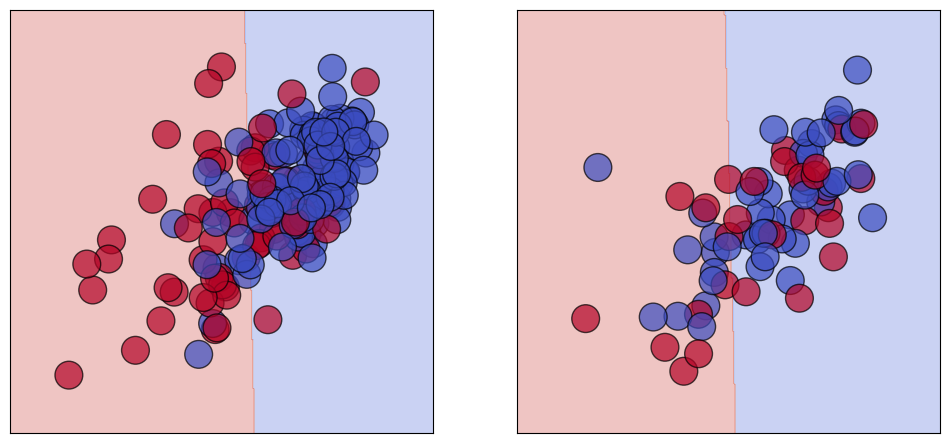

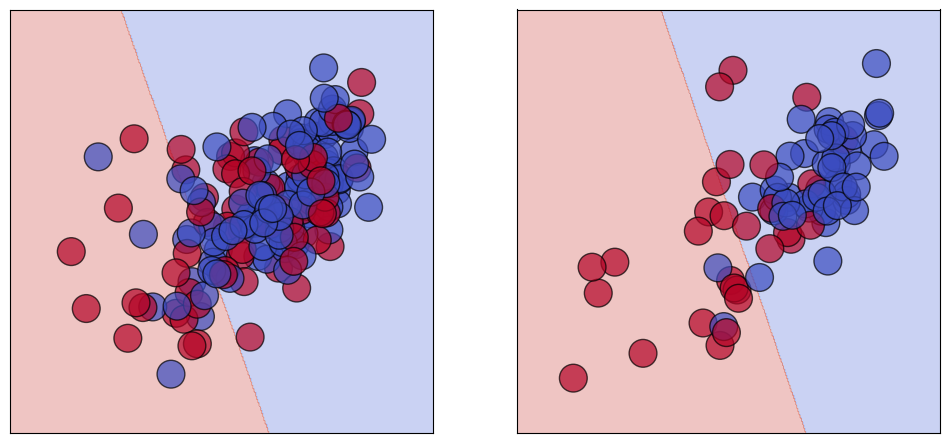

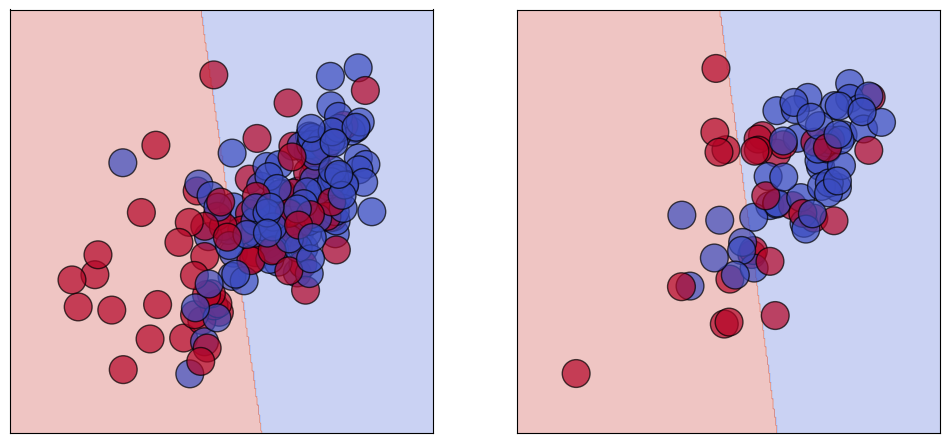

In [4]:
df = pd.read_csv('MEN_cohort.csv')

X = df.loc[:, ['T1C_shape_Sphericity', 'T1C_shape_Flatness']]
y = df.loc[:, 'Label']

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Plotting
for rs, title in zip( [518, 602, 563], 
                      ['highCV_lowTEST', 'lowCV_highTEST', 'matching'] ):
    
  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train, y_train)
  X_test = scaler.transform(X_test)

  model = LinearSVC(random_state=0).fit(X_train, y_train)

  fig, ax = plt.subplots(1, 2, figsize=(12,5.5))

  for i, data in enumerate( [(X_train[:, 0], X_train[:, 1]),  
                            (X_test[:, 0], X_test[:, 1])] ):
    X0, X1 = data[0], data[1]
    if i == 0:
      y_chosen = y_train
    else:
      y_chosen = y_test

    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax[i], model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3)
    ax[i].scatter(X0, X1, c=y_chosen, cmap=plt.cm.coolwarm, s=400, edgecolors='k', 
            alpha=0.7)
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].legend